# bioNER Baseline

In [3]:
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install seaborn

In [4]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import itertools

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

## Loading Data from Kaggle

In [5]:
import os
# os.environ['KAGGLE_USERNAME'] = "steysie" # username from the json file 
# os.environ['KAGGLE_KEY'] = "6469ce63000a8caf2a50989e9bb90b19" # key from the json file

In [6]:
#!kaggle datasets download -d rsnayak/hackathon-disease-extraction-saving-lives-with-ai

In [7]:
#!unzip hackathon-disease-extraction-saving-lives-with-ai.zip

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Data Preprocessing

In [9]:
train.isnull().sum()

id           0
Doc_ID       0
Sent_ID      0
Word       130
tag          0
dtype: int64

In [10]:
train = train.dropna(subset=['Word'])

In [11]:
train.isnull().sum()

id         0
Doc_ID     0
Sent_ID    0
Word       0
tag        0
dtype: int64

In [12]:
len(train['Word'])

4543703

In [13]:
indexNames = train[train['Word'] == ' '].index
 
# Delete these row indexes from dataFrame
train.drop(indexNames, inplace=True)

In [14]:
len(train['Word'])

4543703

In [15]:
# lowercasing
train.Word = train.Word.str.lower()
train.head(3)

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,obesity,O
1,2,1,1,in,O
2,3,1,1,low-,O


In [16]:
train.groupby('tag').size().reset_index(name='counts')

,tag,counts
0,B-indications,53003
1,I-indications,44624
2,O,4446076


## Подготовка данных

Замапим категории в индексы

In [17]:
cat_mapper = {tag: n for n, tag in enumerate(train.tag.unique())}

In [18]:
cat_mapper

{'O': 0, 'B-indications': 1, 'I-indications': 2}

In [19]:
train.tag = train.tag.map(cat_mapper)

In [20]:
# group sentences by id
grouped = train.groupby('Sent_ID').agg(lambda x: x.tolist())

In [21]:
grouped.head()

,id,Doc_ID,Word,tag
Sent_ID,,,,
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[obesity, in, low-, and, middle-income, countr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[we, have, reviewed, the, distinctive, feature...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[obesity, is, rising, in, every, region, of, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[in, lmics, ,, overweight, is, higher, in, wom...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[overweight, occurs, alongside, persistent, bu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [22]:
sents = grouped.Word.tolist()
tags = grouped.tag.tolist()

## Checking the correspondence & other tests

In [23]:
sents[111], tags[111]

(['decreased',
  'peak',
  'arteriovenous',
  'oxygen',
  'difference',
  'during',
  'treadmill',
  'exercise',
  'testing',
  'in',
  'individuals',
  'infected',
  'with',
  'the',
  'human',
  'immunodeficiency',
  'virus',
  '.'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0])

Супер, нужные тэги совпадают со словами, ничего никуда не сдвинулось.

In [24]:
# Cheching that all lengths are consistent and that there are no sentences of length 0
zeros = 0

for i in range(len(tags)):
    if len(tags[i]) != len(sents[i]):
        print(f"Error at position {i}")
    elif len(tags[i]) == 0:
        zeros += 0

print(zeros)

0


In [25]:
maxlen = 25
minlen = 3
num = 0

for n, i in enumerate(tags):
    if len(i) > maxlen:
        maxlen = len(i)
        num = n
    elif len(i) < minlen:
        minlen = len(i)

print(f"The maximum sequence length is {maxlen}, and the minimum sequence length is {minlen}")
print(f"The longest sequence is #{num}")

The maximum sequence length is 3899, and the minimum sequence length is 1
The longest sequence is #96017


### Sentence length statistics

In [26]:
lengths = []

for text in tqdm(sents):
    lengths.append(len(text))

100%|██████████| 191279/191279 [00:00<00:00, 916543.12it/s]


In [27]:
import seaborn as sns
from matplotlib import pyplot as plt

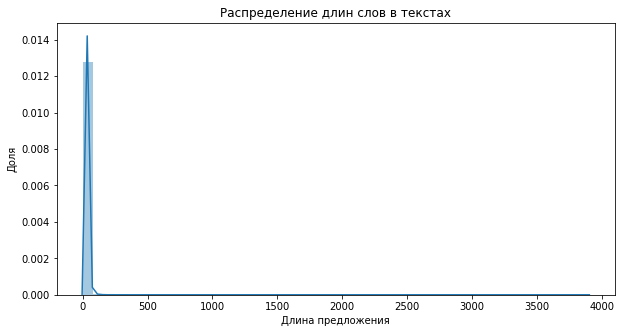

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

Очень много очень длинных "предложений", нужно бы их разделить

In [29]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    if len(out[-1]) == 1:
        out[-2].extend(out[-1])
        out.remove(out[-1])

    return out

In [30]:
class betterGroupedSents:

    def __init__(self):
        self.lengths = 0        
        self.deletions = 0      # will record the deletions of emptified sentences
        self.i_movement = 0     # will record how many words with I tag moved to previous sentence

    def chunkGroupedSents(self, old_sents, tags_raw, maxlen=32):
        l = len(old_sents)
        sents = []

        for i in range(l):
            # if sentence is longer than the specified maxlen, let's chunk it into sequences of roughly specified max length (+1 in case of residuals)
            if len(old_sents[i]) > maxlen:
                sents.extend(chunkIt(old_sents[i], len(old_sents[i])/maxlen))

            else: 
                sents.append(old_sents[i])

        lengths = 0
        deletions = 0 # will record the deletions of emptified sentences
        i_movement = 0 # will record how many words with I tag moved to previous sentence

        for i in range(len(sents)):
            try:
                # len(sents) will change over time so we need to check that we didn't exceed the limit
                if i == len(sents)-2:
                    lengths += len(sents[i])
                    #lengths += len(sents[i+1])
                    #print(lengths)
                    break

                if tags_raw[lengths+len(sents[i])] == 2:    # if tags_raw[lengths+len(sents[i])-1] in [1, 2] and
                    cursor = lengths+len(sents[i])  # index of the first element of the next sequence if the count starts from the current sequence
                    next_len = len(sents[i+1])   # length of the next sequence
                    
                    pairs = zip(sents[i+1], tags_raw[cursor:cursor+next_len])   # to be able to retrieve both the sentence and its tag seq by the same index
                    
                    # get all the starting 2's - so that later we can move them to the previous sequence  But! we should make sure only starting 2's are retrieved not all
                    match = []
                    for w, t in pairs:
                        if t==2:
                            match.append(w)
                        else:
                            break

                    sents[i].extend(match)
                    del sents[i+1][0:len(match)]
                    i_movement += len(match)

                # if the next sequence len == 0 or
                if (sents[i+1]) and (len((sents[i+1])) == 0 or (len(sents[i+1]) <= 3 and (any(x in sents[i+1] for x in ['.','!','?', ';', ')'])))):
                    sents[i].extend(sents[i+1])
                    del sents[i+1]
                    deletions += 1


                lengths += len(sents[i])
            
            except IndexError as e:
                print(e)
                print(lengths)
                print(deletions)
                break
        
        self.lengths = lengths       
        self.deletions = deletions
        self.i_movement = i_movement

        return sents

In [31]:
grFunc = betterGroupedSents()

In [32]:
raw_sents = sents

In [33]:
grouped_sents = grFunc.chunkGroupedSents(raw_sents, train.tag.tolist(), 32)

In [34]:
len(grouped_sents), len(train.tag.tolist())

(220737, 4543703)

In [35]:
print(f"{grFunc.deletions} предложений были присоединены к предыдущим полностью")
print(f"{grFunc.i_movement} слов с тегом I были присоединены к предыдущему предложению")

9059 предложений были присоединены к предыдущим полностью
409 слов с тегом I были присоединены к предыдущему предложению


### Grouping tags

Now the tags need to be grouped according to the lengths of the sentences

In [36]:
# Same on real tags

tags_raw = train.tag.tolist()
tags = []
c = 0


for i in range(len(grouped_sents)):
    try:
        tags.append(tags_raw[c:c+len(grouped_sents[i])])
        c += len(grouped_sents[i])
    except IndexError:
        print(i)

print(len(tags), len(grouped_sents))

220737 220737


In [37]:
# Cheching that all lengths are consistent and that there are no sentences of length 0
zeros = 0

for i in range(len(tags)):
    if len(tags[i]) != len(grouped_sents[i]):
        print(f"Error at position {i}")
    elif len(tags[i]) == 0:
        zeros += 0

print(zeros)

0


In [38]:
maxlen = 25
minlen = 3
num = 0

for n, i in enumerate(tags):
    if len(i) > maxlen:
        maxlen = len(i)
        num = n
    elif len(i) < minlen:
        minlen = len(i)

print(f"The maximum sequence length is {maxlen}, and the minimum sequence length is {minlen}")
print(f"The longest sequence is #{num}")

The maximum sequence length is 39, and the minimum sequence length is 1
The longest sequence is #34363


In [39]:
lengths = []

for text in tqdm(grouped_sents):
    lengths.append(len(text))

100%|██████████| 220737/220737 [00:00<00:00, 894443.13it/s]


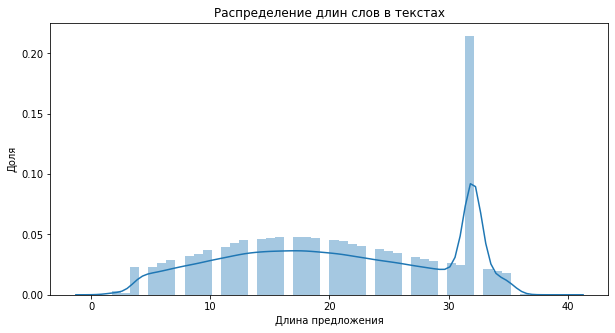

In [40]:
plt.figure(figsize=(10, 5))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

Теперь стало гораздо более равномерно, не считая того, что большинство предложений получились той длины, которую мы указали как относительно максимальную (32 слова)

In [41]:
df = pd.DataFrame(
    {'Sentence': grouped_sents,
     'Tags': tags
    })

In [42]:
a = df.head()

In [43]:
a.Sentence.head().apply(type)

0    <class 'list'>
1    <class 'list'>
2    <class 'list'>
3    <class 'list'>
4    <class 'list'>
Name: Sentence, dtype: object

Пример:

```['p53', 'immunohistochemistry', 'in', 'malignant', 'fibrous', 'histiocytomas', 'and', 'other', 'mesenchymal', 'tumours', '.']
[0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0]```

```['effect', 'of', 'cadmium', 'exposure', 'on', 'primary', 'tumor', 'growth', 'and', 'cell-mediated', 'cytotoxicity', 'in', 'mice', 'bearing', 'msb', 'sarcomas', '.']
[0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0]```

### Train-test split

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df.Sentence.tolist(), df.Tags.tolist(), test_size=0.1, shuffle=True)

In [46]:
train_data = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
test_data = pd.DataFrame({'X_test': X_test, 'y_test': y_test})

In [47]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [48]:
import datetime

In [49]:
# CODE TO SAVE MODELS TO DRIVE

date = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
train_name = f'train_data_sentence-level_{date}.csv'
test_name = f'test_data_sentence-level_{date}.csv'

train_path = f"/sents/{train_name}"   #f"/content/gdrive/My Drive/bioNER datasets/sents/{train_name}"
test_path = f"/sents/{test_name}"     #f"/content/gdrive/My Drive/bioNER datasets/sents/{test_name}"

train_data.to_csv(f"./sents/{train_name}")   #(f"/content/gdrive/My Drive/bioNER datasets/sents/{train_name}")
test_data.to_csv(f"./sents/{test_name}")     #(f"/content/gdrive/My Drive/bioNER datasets/sents/{test_name}")

In [50]:
print(X_train[8])
print(y_train[8])

['basic', 'fibroblast', 'growth', 'factor', '(', '10', 'ng/ml', ')', 'with', 'low', 'concentration', 'of', 'fetal', 'bovine', 'serum', 'in', 'the', 'culture', 'medium', 'promoted', 'the', 'proliferation', 'of', 'chondrocytes', 'significantly', ',', 'and', 'this', 'effect', 'reached', 'its', 'maximum']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [51]:
# train_data = pd.read_csv(train_path).iloc[:, -2:]
# test_data = pd.read_csv(test_path).iloc[:, -2:]

In [52]:
a = train_data.head()
a.X_train.head().apply(type)

0    <class 'list'>
1    <class 'list'>
2    <class 'list'>
3    <class 'list'>
4    <class 'list'>
Name: X_train, dtype: object

In [53]:
train_data = train_data.dropna(subset=['X_train'])
test_data = test_data.dropna(subset=['X_test'])

In [54]:
#train_data.isnull().sum()
test_data.isnull().sum()

X_test    0
y_test    0
dtype: int64

In [55]:
# X_train, X_test, y_train, y_test = train_data.X_train, test_data.X_test, train_data.y_train, test_data.y_test

In [56]:
print(f"Train dataset has {len(X_train)} sentences and test dataset has {len(X_test)} sentences")

Train dataset has 198663 sentences and test dataset has 22074 sentences


In [57]:
# train.Sentence.apply(lambda x: json.loads(x)) <- to convert string to list

## Mapping data to indexes

In [58]:
# the START-STOP tags are from the tutorial implementation (the rest of the code is below).
START_TAG = "<START>"
STOP_TAG = "<STOP>"
word_to_ix = {}

for sentence in df.Sentence:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = cat_mapper
tag_to_ix.update({START_TAG: 3, STOP_TAG: 4})

In [59]:
len(word_to_ix), len(tag_to_ix)

(158163, 5)

In [60]:
word_to_ix['PAD'] = len(word_to_ix)
word_to_ix['UNK'] = len(word_to_ix)

In [61]:
#import ast   # for targets

### Word Data - dataset compiler

In [62]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length = 39, pad_token='PAD', unk_token='UNK', verbose=True):
        
        super().__init__()
        
        self.sequence_length = sequence_length
        self.x_data = []
        self.y_data = y_data  
        self.word2index = word2index
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        #words = [word.lower() for word in text]

        return text
        
    def load(self, data, verbose=True):
             
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)  
        
        for text in data_iterator:
            
            words = self.process_text(text)
            indexed_words = self.indexing(words) 
            self.x_data.append(indexed_words)


    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    # def padding(self, sequence):
        
    #     # Ограничить длину self.sequence_length
    #     # если длина меньше максимально - западить
        
    #     ### CODE ###

    #     if len(sequence) > self.sequence_length:
    #         sequence = sequence[:self.sequence_length]
    #         return sequence

    #     elif len(sequence) < self.sequence_length:
    #         sequence = sequence + [self.pad_index]*(self.sequence_length-len(sequence))
    #         return sequence

    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        # x = self.padding(x)
        # x = ast.literal_eval(x)    # we have lists in dataframe values but when we try to retrieve them, their type = str 
        x = torch.Tensor(x).long()    
        y = self.y_data[idx]
        # y = ast.literal_eval(y)    # this function allows us to make list-like-strings lists
        y = torch.Tensor(y).long()

        return x, y
    

In [63]:
# dataset = WordData(df.Sentence.tolist(), df.Tags.tolist(), word_to_ix)

In [64]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [65]:
train_dataset = WordData(X_train, y_train, word_to_ix)
test_dataset = WordData(X_test, y_test, word_to_ix)

# train_loader = DataLoader(train_dataset, batch_size=254)
# test_loader = DataLoader(test_dataset, batch_size=254)

Loading data: 100%|██████████| 22074/22074 [00:00<00:00, 78214.68it/s]


In [66]:
# tiny_batch for testing

tiny_batch = int(0.99 * len(test_dataset))
the_rest = len(test_dataset) - tiny_batch
tiny_train, tiny_test = torch.utils.data.random_split(test_dataset, [tiny_batch, the_rest])

# train_loader = DataLoader(tiny_train, batch_size=64)
# test_loader = DataLoader(tiny_test, batch_size=64)

In [67]:
for x, y in train_dataset:
    break

In [68]:
x

tensor([   16,  3331,     3, 10605,   551,    90,  3372,     1, 24779, 83346,
            1, 25061,    12])

In [69]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## biLSTM + CRF Tutorial Implementation

https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

In [70]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [71]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [72]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(self.device),
                torch.randn(2, 1, self.hidden_dim // 2).to(self.device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(self.device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)   # sentence.size(0)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long, device=self.device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(self.device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [73]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 64

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [86]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(train.Word[0], word_to_ix) #.to(device)
    print(model(precheck_sent.to(device)))

(tensor(6.0565, device='cuda:0'), [0, 1, 0, 1, 0, 1, 0])


In [76]:
# model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
# #optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [87]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [79]:
# Save the model to drive
# mount notebook to google drive, save the results

# from google.colab import drive
# drive.mount('/content/gdrive')

In [88]:
epochs = 8
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.
accuracies = []
precisions = []
recalls = []
f1s = []

model_save_name = 'bio_lstm+crf_200d_sentence_model_2019-12-19.pt'
path = f"./models/{model_save_name}" 

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []

    progress_bar = tqdm(total=int(len(train.Word)*0.9), desc='Epoch {}'.format(epoch + 1))

    for x, y in train_dataset:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(x, y)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    torch.save(model.state_dict(), path)

    for x, y in test_dataset:
        
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():           
            pred = model(x)[1]

        # pred.shape => (128, 5) => (batch_size, targets). Need to choose the *index* (!) with the largest value.
        #pred_values, pred_indices = pred.max(1)   # already counted in the viterbi algorithm (?)

        pred_cpu = pred #.cpu()
        y_cpu = y.cpu()

        test_preds.append(pred)  #.numpy())
        test_targets.append(y_cpu.numpy())

        loss = model.neg_log_likelihood(x, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train = {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    accuracy = accuracy_score(test_targets, test_preds)
    precision = precision_score(test_targets, test_preds, average='macro')
    recall = recall_score(test_targets, test_preds, average='macro')
    f1 = f1_score(test_targets, test_preds, average='macro')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print('Test: accuracy = {:.3f}'.format(accuracy))
    print('Test: precision = {:.3f}'.format(precision))
    print('Test: recall = {:.3f}'.format(recall))
    print('Test: f1_score = {:.3f}'.format(f1))
        
    # early stopping

    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break   

# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(train.Word[0], word_to_ix)
    print(model(precheck_sent.to(device)))
# We got it!

# model_save_name = 'bio_lstm+crf_200d_sentence_model.pt'
# path = f"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

Epoch 1: 4090557it [4:04:38, 260.32it/s, train_loss=0.418]                               


Losses: train = 0.553, test = 0.429


Epoch 2:   0%|          | 33/4089332 [00:00<4:25:44, 256.48it/s, train_loss=0.414] 

Test: accuracy = 0.990
Test: precision = 0.873
Test: recall = 0.748
Test: f1_score = 0.802


Epoch 2: 4090557it [4:05:07, 264.33it/s, train_loss=0.35]                                


Losses: train = 0.374, test = 0.394


Epoch 3:   0%|          | 33/4089332 [00:00<4:06:13, 276.81it/s, train_loss=0.348] 

Test: accuracy = 0.991
Test: precision = 0.872
Test: recall = 0.788
Test: f1_score = 0.826


Epoch 3: 4090557it [4:04:47, 265.05it/s, train_loss=0.318]                               


Losses: train = 0.328, test = 0.377


Epoch 4:   0%|          | 33/4089332 [00:00<4:34:36, 248.19it/s, train_loss=0.315]

Test: accuracy = 0.991
Test: precision = 0.884
Test: recall = 0.793
Test: f1_score = 0.834


Epoch 4: 4090557it [4:04:42, 287.58it/s, train_loss=0.313]                               


Losses: train = 0.300, test = 0.373


Epoch 5:   0%|          | 33/4089332 [00:00<3:50:46, 295.34it/s, train_loss=0.308]

Test: accuracy = 0.991
Test: precision = 0.862
Test: recall = 0.813
Test: f1_score = 0.836


Epoch 5: 4090557it [4:04:53, 276.68it/s, train_loss=0.273]                               


Losses: train = 0.282, test = 0.368


Epoch 6:   0%|          | 33/4089332 [00:00<4:09:06, 273.59it/s, train_loss=0.271] 

Test: accuracy = 0.991
Test: precision = 0.868
Test: recall = 0.817
Test: f1_score = 0.841


Epoch 6: 4090557it [4:04:48, 286.14it/s, train_loss=0.273]                               


Losses: train = 0.269, test = 0.370
Test: accuracy = 0.991
Test: precision = 0.869
Test: recall = 0.816
Test: f1_score = 0.841
Early stopping
(tensor(-17.8610, device='cuda:0'), [0, 0, 0, 0, 0, 0, 0])


### Some Graph Statistics

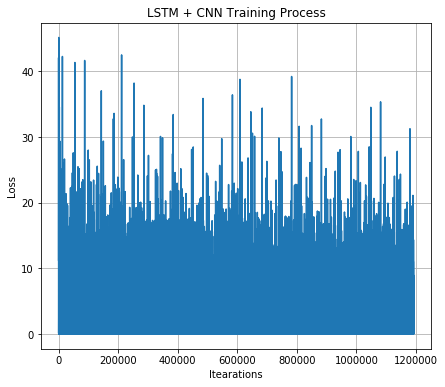

In [89]:
plt.figure(figsize=(7, 6))
plt.title('LSTM + CNN Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [90]:
cm = confusion_matrix(test_preds, test_targets)

In [91]:
categories = ['O', 'B-indications', 'I-indications'] # {'O': 0, 'B-indications': 1, 'I-indications': 2}

In [93]:
import seaborn as sn

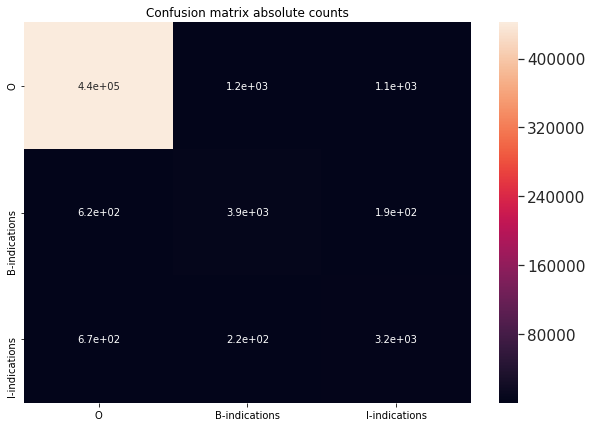

In [94]:
df_cm = pd.DataFrame(cm, categories, categories)
plt.figure(figsize = (10,7))
plt.title("Confusion matrix absolute counts")
sn.set(font_scale=1.4)   # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10})  # font size

plt.show()

In [95]:
cm_normalized = cm / cm.astype(np.float).sum(axis=1)

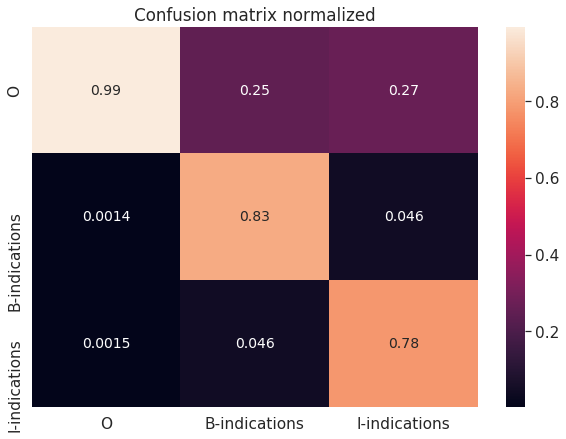

In [96]:
df_cm = pd.DataFrame(cm_normalized, categories, categories)
plt.figure(figsize = (10,7))
plt.title("Confusion matrix normalized")
sn.set(font_scale=1.4)   # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14})  # font size

plt.show()

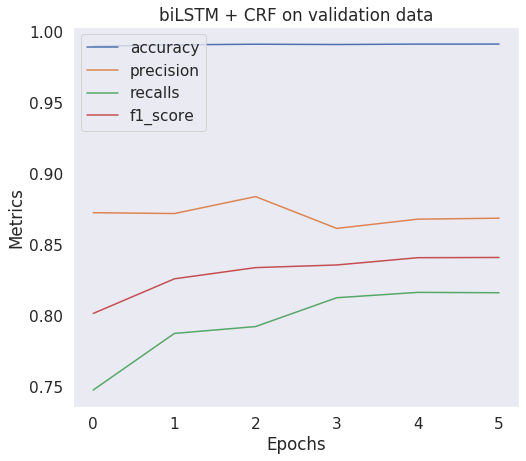

In [97]:
plt.figure(figsize=(8, 7))
plt.title('biLSTM + CRF on validation data')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.grid()

plt.plot(accuracies)
plt.plot(precisions)
plt.plot(recalls)
plt.plot(f1s)

plt.legend(['accuracy', 'precision', 'recalls', 'f1_score'], loc='upper left')

plt.show()